In [ ]:
import argparse
import datetime
import json
import logging
import os
import sys

from tqdm import tqdm

import lib_run_single
from desktop_env.desktop_env import DesktopEnv
from gui_agents.s3.agents.agent_s import AgentS3
from gui_agents.s3.agents.grounding import OSWorldACI

from types import SimpleNamespace

In [ ]:
args = SimpleNamespace(
    # environment config
    path_to_vm=None,
    provider_name="docker",          # <--- not vmware
    headless=True,
    action_space="pyautogui",
    # observation_type="a11y_tree",
    observation_type="screenshot",
    screen_width=1920,
    screen_height=1080,
    sleep_after_execution=1.0,
    max_steps=15,                     # small for debugging

    # agent config
    max_trajectory_length=1,
    test_config_base_dir="evaluation_examples",

    # main LM config (Ollama llama3.2:3b) now testing with llama3.1:8b
    # deepseek-llm:7b(too slow) llama3.2:3b(bad reasoning) llama3.1:8b(best so far)
    model="llama3.1:8b",
    temperature=0.2,
    model_provider="openai",         # Agent-S uses OpenAI-style client
    model_url="http://localhost:11434/v1",
    model_api_key="ollama",
    model_temperature=0.2,

    # grounding model config (reuse same endpoint/model for now) testing with UI-TARS
    ground_provider="openai",
    ground_url="http://localhost:11434/v1",
    ground_api_key="ollama",
    ground_model="hf.co/bartowski/UI-TARS-2B-SFT-GGUF:latest",
    grounding_width=1920,
    grounding_height=1080,

    # example config
    domain="all",
    test_all_meta_path="evaluation_examples/test_all.json",

    # logging / results
    result_dir="./results",
)

In [3]:
# Build engine params
engine_params = {
    "engine_type": args.model_provider,
    "model": args.model,
    "base_url": getattr(args, "model_url", ""),
    "api_key": getattr(args, "model_api_key", ""),
    "temperature": getattr(args, "model_temperature", None),
}

engine_params_for_grounding = {
    "engine_type": args.ground_provider,
    "model": args.ground_model,
    "base_url": getattr(args, "ground_url", ""),
    "api_key": getattr(args, "ground_api_key", ""),
    "grounding_width": args.grounding_width,
    "grounding_height": args.grounding_height,
}

In [4]:
# OSWorld environment (Docker provider)
env = DesktopEnv(
    provider_name=args.provider_name,
    path_to_vm=args.path_to_vm,
    action_space=args.action_space,
    screen_size=(args.screen_width, args.screen_height),
    headless=args.headless,
    os_type="Ubuntu",
    require_a11y_tree=args.observation_type in ["a11y_tree", "screenshot_a11y_tree", "som"],
    enable_proxy=False,   # <--- TURNED OFF for now
)

# Agent-S grounding agent
grounding_agent = OSWorldACI(
    env=env,
    platform="linux",
    engine_params_for_generation=engine_params,
    engine_params_for_grounding=engine_params_for_grounding,
    width=args.screen_width,
    height=args.screen_height,
)

# Agent-S3 main agent
agent = AgentS3(
    engine_params,
    grounding_agent,
    platform="linux",
)

KVM device not found, running without hardware acceleration (will be slower)


In [5]:
with open(args.test_all_meta_path, "r", encoding="utf-8") as f:
    test_all_meta = json.load(f)

# For a first run, choose the first domain and the second example ID
domain = next(iter(test_all_meta.keys()))
example_id = test_all_meta[domain][5]

print("Domain:", domain)
print("Example ID:", example_id)

config_file = os.path.join(
    args.test_config_base_dir, f"examples/{domain}/{example_id}.json"
)
print("Config file path:", config_file)

with open(config_file, "r", encoding="utf-8") as f:
    example = json.load(f)

print("Instruction:", example["instruction"])

Domain: chrome
Example ID: 2ad9387a-65d8-4e33-ad5b-7580065a27ca
Config file path: evaluation_examples/examples/chrome/2ad9387a-65d8-4e33-ad5b-7580065a27ca.json
Instruction: Can you make a new folder for me on the bookmarks bar in my internet browser? Let's call it 'Favorites.'


In [6]:
scores: list[float] = []
example_result_dir = os.path.join(
    args.result_dir,
    args.action_space,
    args.observation_type,
    args.model,
    domain,
    example_id,
)
os.makedirs(example_result_dir, exist_ok=True)

print("Result dir:", example_result_dir)

lib_run_single.run_single_example(
    agent,
    env,
    example,
    args.max_steps,
    example["instruction"],
    args,
    example_result_dir,
    scores,
)

print("Scores list:", scores)

Result dir: ./results/pyautogui/screenshot/llama3.1:8b/chrome/2ad9387a-65d8-4e33-ad5b-7580065a27ca
Response success!
Response success!


Response formatting error on attempt 0 for llama3.1:8b. Response: Since the trajectory is going according to plan, we can continue with the next step.

(Screenshot Analysis)
The screenshot shows the internet browser application open. We need to navigate to its bookmark settings.

(Next Action)
To create a new folder for 'Favorites' on the bookmarks bar, we need to click on the "Bookmarks" or "Bookmark Manager" button in the browser and then select the option to create a new folder.

(Grounded Action)
```python
agent.type("address bar", "bookmarks")
agent.hotkey(['ctrl', 'shift', 'b'])
```
This code types "bookmarks" into the address bar, which should open the bookmark manager page, and then presses the hotkeys to open the bookmarks manager. Incorrect code: There must be a single agent action in the code response., Incorrect code: The agent action must be a valid function and use valid parameters from the docstring list.


Response success!
Response success!
Response success!
RAW GROUNDING MODEL RESPONSE: [102, 34]
Response success!
RAW GROUNDING MODEL RESPONSE: [102, 34]
Response success!
Response success!
Response success!
RAW GROUNDING MODEL RESPONSE: [105, 263]
Response success!
RAW GROUNDING MODEL RESPONSE: [105, 263]
Response success!
Response success!
Response success!
RAW GROUNDING MODEL RESPONSE: [102, 254]
Response success!
RAW GROUNDING MODEL RESPONSE: [102, 254]
Response success!
Response success!
Scores list: [0.0]


In [1]:
env.close()

NameError: name 'env' is not defined

In [62]:
import base64
import os
import re

from openai import OpenAI
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# If you're using Ollama's OpenAI-compatible endpoint for grounding:
GROUND_BASE_URL = "http://localhost:11434/v1"
GROUND_MODEL = "llama3.2-vision:latest"
GROUND_API_KEY = "ollama"  # can be anything non-empty for Ollama

client = OpenAI(
    base_url=GROUND_BASE_URL,
    api_key=GROUND_API_KEY,
)

def call_grounding_model(image_path: str, query: str) -> str:
    """Send one screenshot + prompt to the grounding model, return raw text response."""
    with open(image_path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")

    resp = client.chat.completions.create(
        model=GROUND_MODEL,
        temperature=0.0,
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": (
                            "You are a grounding model for GUI screenshots.\n"
                            "Given the screenshot of resolution 1920x1080, locate the requested UI element.\n"
                            "Respond with EXACTLY one XML tag in this format:\n"
                            '<points x1=\"X\" y1=\"Y\" alt=\"description\">description</points>\n\n'
                            f"Task: locate {query}"
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{b64}"
                        },
                    },
                ],
            }
        ],
    )

    text = resp.choices[0].message.content.strip()
    return text

def parse_points(xml: str):
    """Extract (x1, y1, alt_text) from a <points ...> XML string."""
    m = re.search(r'<points\s+[^>]*x1="(\d+)"\s+y1="(\d+)"[^>]*>(.*?)</points>', xml, re.DOTALL)
    if not m:
        raise ValueError(f"Could not parse points from response:\n{xml}")
    x = int(m.group(1))
    y = int(m.group(2))
    alt = m.group(3).strip()
    return x, y, alt

In [69]:
image_path = "test.png"
query = "the 'menu' (three dots) button on the Chrome browser window"

raw = call_grounding_model(image_path, query)
print("RAW RESPONSE:")
print(raw)

x, y, alt = parse_points(raw)
print(f"\nParsed coordinates: x={x}, y={y}")
print(f"Alt text: {alt}")

RAW RESPONSE:
<points x1="1741" y1="24" alt="menu button">menu button</points>

Parsed coordinates: x=1741, y=24
Alt text: menu button


Saved annotated image to test_marked.png


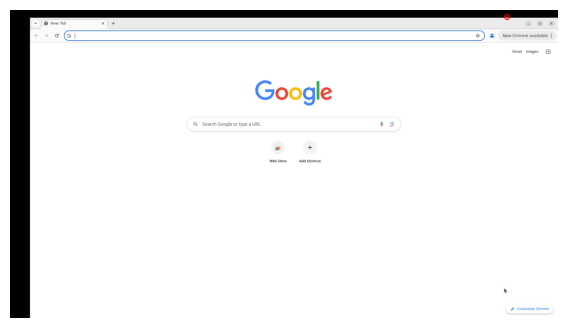

In [70]:
# Load original image
img = Image.open(image_path).convert("RGB")
draw = ImageDraw.Draw(img)
# x = x * 1920/1280
# y = y * 1080/720
# Draw a small marker (circle) around the predicted point
r = 10  # radius in pixels
left_up = (x - r, y - r)
right_down = (x + r, y + r)
draw.ellipse([left_up, right_down], outline="red", width=3)

# Optionally draw a tiny crosshair
draw.line((x - r, y, x + r, y), fill="red", width=2)
draw.line((x, y - r, x, y + r), fill="red", width=2)

# Save and show
marked_path = "test_marked.png"
img.save(marked_path)
print(f"Saved annotated image to {marked_path}")

plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis("off")
plt.show()

In [30]:
x,y

(1950.0, 150.0)

In [2]:
from PIL import Image
# print the size of the image
img = Image.open(path_to_image)
print("Image size:", img.size)  # (width, height)

Image size: (1920, 1080)


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

/home/ubuntu/miniconda3/envs/ecua/lib/python3.11/site-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.69G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


(949,969)
Raw model output:
 (949,969)
Predicted click in original image coords: 1822 1046


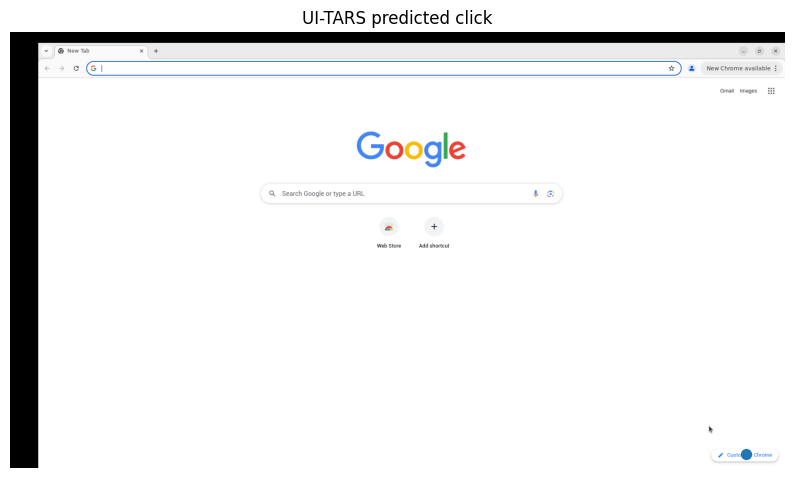

In [1]:
import re
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq


MODEL_ID = "ByteDance-Seed/UI-TARS-7B-DPO"


# ==== 1. Load processor + model on CPU only ====
processor = AutoProcessor.from_pretrained(MODEL_ID)


model = AutoModelForVision2Seq.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,   # smaller than float32, fine on CPU
    device_map="cpu",  
    low_cpu_mem_usage=True,
)
model.eval()


# =====================
# 2. Core UI-TARS call
# =====================
def build_uground_messages(description: str):
    """
    Build chat messages in the format expected by Qwen2-VL-style processors,
    with a local image (provided separately to `processor`).
    """
    return [
        {
            "role": "user",
            "content": [
                {"type": "image"},  # actual pixels passed via images=[...]
                {
                    "type": "text",
                    "text": f"""
Your task is to identify the precise coordinates (x, y) of a specific area/element/object on the screen based on the description.


- Your answer MUST be a single string in the format (x, y).
- x and y MUST be integers in the range [0, 1000).
- The coordinates are defined in a 1000x1000 coordinate system, where (0, 0) is the top-left and (999, 999) is the bottom-right.
- Aim to click at the center or a representative point of the described element.


Description: {description}


Answer:"""
                },
            ],
        },
    ]


def call_ui_tars_raw(image_path: str, query: str) -> tuple[str, int, int, int, int]:
    """
    Send one screenshot + grounding query to UI-TARS, return:
    (raw_text_response, orig_width, orig_height, proc_width, proc_height).


    We:
    - load the original image
    - compute smart_resize() dimensions
    - resize to (proc_width, proc_height) for the model
    - prompt in Thought/Action format with click(start_box='(x,y)')
    """
    # Load original image
    img = Image.open(image_path).convert("RGB")
    orig_w, orig_h = img.size


    # # Use smart_resize as the actual model input size
    # proc_h, proc_w = smart_resize(orig_h, orig_w)
    # img_proc = orig_img.resize((proc_w, proc_h), Image.LANCZOS)


    # Prompt in UI-TARS-style format
    # (COMPUTER_USE-style Thought + Action with click(start_box='(x,y)'))
    prompt = build_uground_messages(query)


    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},  # the actual image is passed via `images=` below
                {"type": "text", "text": prompt},
            ],
        },
    ]


    # Build chat prompt string (text only)
    chat_prompt = processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=False,
    )


    # Turn prompt + processed image into model inputs
    inputs = processor(
        text=[chat_prompt],
        images=[img],
        return_tensors="pt",
    )


    # Move to CPU (model is on CPU)
    inputs = {k: v.to("cpu") for k, v in inputs.items()}


    with torch.inference_mode():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            temperature=0.0,
        )


    # Decode only the newly generated tokens
    gen_ids = outputs[0][inputs["input_ids"].shape[-1]:]
    reply = processor.decode(gen_ids, skip_special_tokens=True).strip()


    print(reply)


    return reply, orig_w, orig_h


def parse_xy_from_string(text: str) -> tuple[int, int]:
    """
    Extract (x, y) from a string like '(123, 456)'.
    """
    m = re.search(r"\(\s*(\d+)\s*,\s*(\d+)\s*\)", text)
    if not m:
        raise ValueError(f"Could not parse coordinates from: {text!r}")
    x, y = int(m.group(1)), int(m.group(2))
    if not (0 <= x < 1000 and 0 <= y < 1000):
        # Not strictly necessary, but good sanity check
        raise ValueError(f"Coordinates out of [0,1000) range: {(x, y)} from {text!r}")
    return x, y




def scale_to_pixels(x_1000: int, y_1000: int, width: int, height: int) -> tuple[int, int]:
    """
    Map model coordinates in [0,1000) to pixel coordinates of the original image.
    """
    x_px = int(x_1000 / 1000 * width)
    y_px = int(y_1000 / 1000 * height)
    # Clamp just in case of boundary issues
    x_px = max(0, min(width - 1, x_px))
    y_px = max(0, min(height - 1, y_px))
    return x_px, y_px


def call_grounding_model(image_path: str, query: str) -> tuple[int, int, str]:
    raw, orig_w, orig_h = call_ui_tars_raw(image_path, query)
        # 6) Parse (x, y) in [0,1000)
    x_1000, y_1000 = parse_xy_from_string(raw)


    # 7) Map to pixel coordinates
    x_px, y_px = scale_to_pixels(x_1000, y_1000, orig_w, orig_h)


    # x, y = response_to_click_xy(raw, orig_w, orig_h)
    return x_px, y_px, raw


In [2]:
import matplotlib.pyplot as plt


img_path = "test.png"
query = "the menu button (three dots) at the bottom right corner of the window"


x, y, raw = call_grounding_model(img_path, query)
print("Raw model output:\n", raw)
print("Predicted click in original image coords:", x, y)


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


(987,86)
Raw model output:
 (987,86)
Predicted click in original image coords: 1895 92


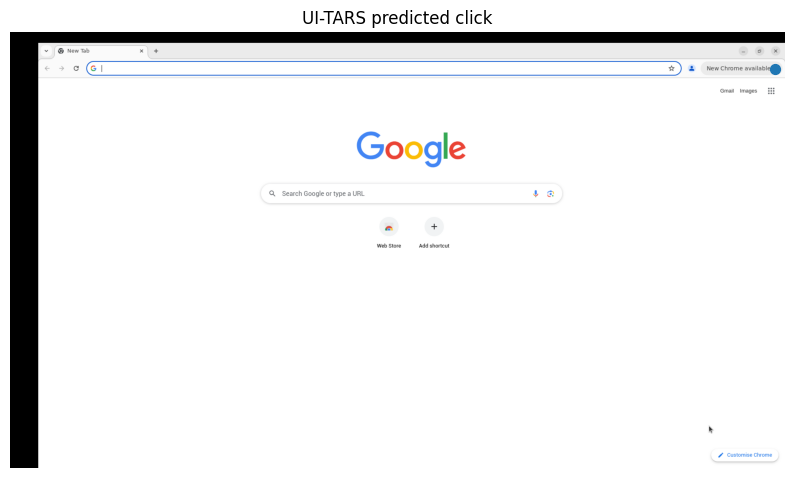

In [3]:
img = Image.open(img_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.scatter([x], [y], s=50)
plt.title("UI-TARS predicted click")
plt.axis("off")
plt.savefig("coordinate_process_image_som.png", dpi=300, bbox_inches="tight")